<a href="https://colab.research.google.com/github/sdikici/Demand_Forecasting_Prophet_DeepAR/blob/main/DeepAR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d sercandikici/merged-dataset-electricty-weather-for-modelling
! unzip merged-dataset-electricty-weather-for-modelling.zip

Dataset URL: https://www.kaggle.com/datasets/sercandikici/merged-dataset-electricty-weather-for-modelling
License(s): unknown
100% 104k/104k [00:00<00:00, 522kB/s]
100% 104k/104k [00:00<00:00, 522kB/s]
Archive:  merged-dataset-electricty-weather-for-modelling.zip
  inflating: merged_data.csv         


In [3]:
!pip install gluonts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.0 MB/s eta 0:00:00


In [4]:
pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [5]:
pip install mxnet --upgrade

In [146]:
import numpy as np
np.bool = np.bool_

In [147]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon
import json
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [148]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def r_squared(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mean_y_true = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y_true) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [365]:
mx.random.seed(43)
np.random.seed(43)

In [391]:
df_merged = pd.read_csv("merged_data.csv")
df_merged['settlement_date'] = pd.to_datetime(df_merged['settlement_date'])
df_merged

,settlement_date,tsd,is_holiday,temp
0,2021-01-01 00:00:00,28552.00,1.0,1.55
1,2021-01-01 02:00:00,26579.75,1.0,1.60
2,2021-01-01 04:00:00,25236.00,1.0,0.55
3,2021-01-01 06:00:00,25792.25,1.0,-0.35
4,2021-01-01 08:00:00,28162.75,1.0,-0.10
...,...,...,...,...
13136,2023-12-31 16:00:00,34006.00,0.0,7.60
13137,2023-12-31 18:00:00,32273.00,0.0,8.20
13138,2023-12-31 20:00:00,27456.50,0.0,8.45
13139,2023-12-31 22:00:00,24139.25,0.0,8.35


In [392]:
df_model_1 = df_merged[["tsd","settlement_date"]]
df_model_1= df_model_1.set_index("settlement_date")
df_model_1

,tsd
settlement_date,
2021-01-01 00:00:00,28552.00
2021-01-01 02:00:00,26579.75
2021-01-01 04:00:00,25236.00
2021-01-01 06:00:00,25792.25
2021-01-01 08:00:00,28162.75
...,...
2023-12-31 16:00:00,34006.00
2023-12-31 18:00:00,32273.00
2023-12-31 20:00:00,27456.50


In [394]:
split_from = 90*12 #train test split is from 90days

train_data = df_model_1[:-split_from]
test_data = df_model_1[-split_from:]
val_split_index = int(len(train_data) * 0.8)  # 80% for training, 20% for validation
train_data, valid_data = train_data[:val_split_index], train_data[val_split_index:]

print(train_data.shape)
print(test_data.shape)

(9648, 1)
(1080, 1)


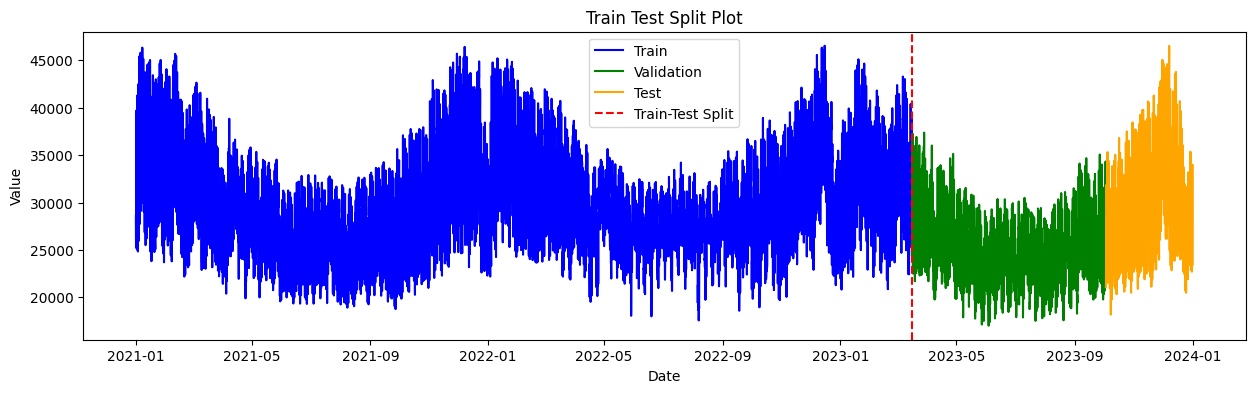

In [396]:
plt.figure(figsize=(15,4))
plt.plot(train_data.index,train_data["tsd"],color="blue", label="Train")
plt.plot(valid_data.index,valid_data["tsd"],color="green", label="Validation")
plt.plot(test_data.index,test_data["tsd"], color="orange", label="Test")
plt.axvline(train_data.index[-1], color="red", linestyle="--", label="Train-Test Split")

plt.title('Train Test Split Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [466]:
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction

freq = "2H"
days_to_predict=15 #days
prediction_length = days_to_predict*12
context_length = prediction_length *2
num_layers = 2
num_cells = 64
epochs = 10
num_batches_per_epoch = 190
batch_size= 64
learning_rate = 0.001
dropout_rate = 0.001
scheduler = LearningRateReduction(patience=3, base_lr=learning_rate, objective='min')


In [467]:
estimator = DeepAREstimator (freq=freq,
                             context_length=context_length, #how much previous observation we need to take to predict future events
                             prediction_length=prediction_length,
                             num_layers=num_layers,
                             num_cells=num_cells,
                             batch_size=batch_size,
                             dropout_rate=dropout_rate,
                             trainer= Trainer(epochs=epochs,
                                              num_batches_per_epoch=num_batches_per_epoch,
                                              callbacks=[scheduler]
                                              )
                                              )

In [468]:
train_ds = ListDataset(
    [{"start":train_data.index[0],
      "target":train_data.tsd}],
    freq=freq)


valid_ds = ListDataset(
    [{"start":valid_data.index[0],
      "target":valid_data.tsd}],
    freq=freq)


In [418]:
#next(iter(train_ds))

{'start': Period('2021-01-01 00:00', '2H'),
 'target': array([28552.  , 26579.75, 25236.  , ..., 39380.25, 34136.  , 27487.  ],
       dtype=float32)}

In [469]:
m1 = estimator.train(training_data=train_ds, validation_data=valid_ds)

100%|██████████| 190/190 [01:55<00:00,  1.64it/s, epoch=1/10, avg_epoch_loss=9.3] 
1it [00:00,  2.55it/s, epoch=1/10, validation_avg_epoch_loss=8.64]
100%|██████████| 190/190 [01:55<00:00,  1.65it/s, epoch=2/10, avg_epoch_loss=8.58]
1it [00:00,  2.70it/s, epoch=2/10, validation_avg_epoch_loss=8.67]
100%|██████████| 190/190 [01:53<00:00,  1.67it/s, epoch=3/10, avg_epoch_loss=8.4]
1it [00:00,  2.74it/s, epoch=3/10, validation_avg_epoch_loss=8.36]
100%|██████████| 190/190 [01:54<00:00,  1.66it/s, epoch=4/10, avg_epoch_loss=8.28]
1it [00:00,  2.68it/s, epoch=4/10, validation_avg_epoch_loss=8.26]
100%|██████████| 190/190 [01:53<00:00,  1.67it/s, epoch=5/10, avg_epoch_loss=8.19]
1it [00:00,  2.65it/s, epoch=5/10, validation_avg_epoch_loss=8.49]
100%|██████████| 190/190 [01:54<00:00,  1.67it/s, epoch=6/10, avg_epoch_loss=8.12]
1it [00:00,  2.84it/s, epoch=6/10, validation_avg_epoch_loss=8.18]
100%|██████████| 190/190 [01:54<00:00,  1.66it/s, epoch=7/10, avg_epoch_loss=8.07]
1it [00:00,  2.63i

create subset of test data for testing

In [476]:
#subset_start = test_data.index[0]
#subset_end = subset_start + pd.Timedelta((prediction_length*2), unit="H")  # prediction_length is in 2-hour intervals

#subset = test_data.loc[subset_start:subset_end]


In [483]:
test_ds = ListDataset(
    [{"start":test_data.index[0],
      "target":test_data.tsd}],
    freq=freq
)

In [484]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds,
    predictor=m1,
    num_samples=100
)
forecasts = list(forecast_it)
tss = list(ts_it)

create forecasts df

In [485]:
start_date = forecasts[0].start_date.start_time
samples = forecasts[0].quantile(0.5).T
index = pd.date_range(start=start_date, periods=len(samples), freq=freq)
forecast_df = pd.DataFrame(samples, index=index)
forecast_df.columns = ["median_prediction"]
forecast_df

,median_prediction
2023-12-25 02:00:00,22204.050781
2023-12-25 04:00:00,21731.927734
2023-12-25 06:00:00,27649.876953
2023-12-25 08:00:00,31555.289062
2023-12-25 10:00:00,32460.863281
...,...
2023-12-31 16:00:00,28091.224609
2023-12-31 18:00:00,27759.115234
2023-12-31 20:00:00,24881.943359
2023-12-31 22:00:00,22122.156250


In [486]:
test_days = test_data[(test_data.index >= forecast_df.index[0])&(test_data.index <= forecast_df.index[-1])]
test_days

,tsd
settlement_date,
2023-12-25 02:00:00,21430.75
2023-12-25 04:00:00,20477.50
2023-12-25 06:00:00,21974.75
2023-12-25 08:00:00,25665.00
2023-12-25 10:00:00,28835.50
...,...
2023-12-31 16:00:00,34006.00
2023-12-31 18:00:00,32273.00
2023-12-31 20:00:00,27456.50


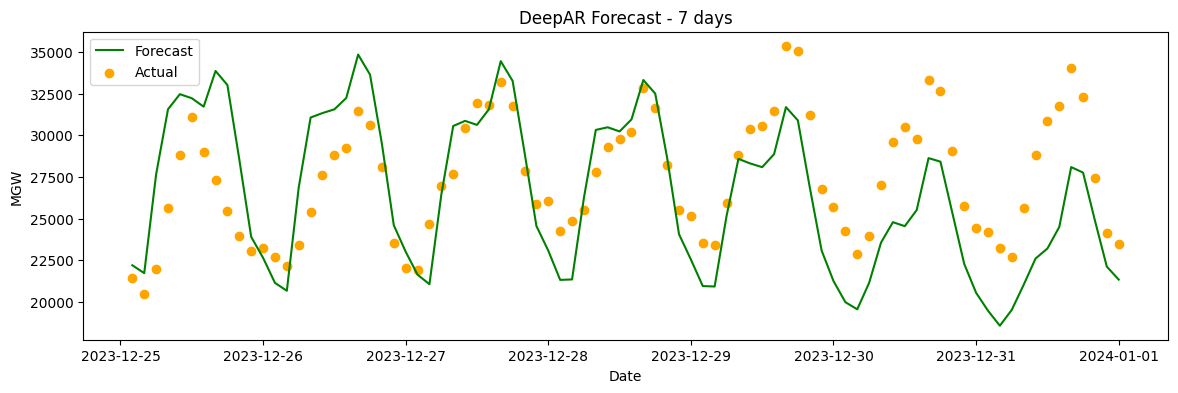

In [487]:
def forecast_plot(forecast_days,test_days, days):

  fig, ax = plt.subplots(figsize=(14, 4))
  ax.plot(forecast_df.index, forecast_df['median_prediction'], label='Forecast', color='green')
  ax.scatter(test_days.index, test_days['tsd'], label='Actual', color='orange')
  ax.set_xlabel('Date')
  ax.set_ylabel('MGW')
  plt.title(f'DeepAR Forecast - {days} days')
  plt.legend()
  plt.show()

forecast_plot(forecast_df,test_days,days_to_predict)

In [488]:
mape_1 = mean_absolute_percentage_error(test_days["tsd"],forecast_df["median_prediction"])
rmse_1 = root_mean_squared_error(test_days["tsd"],forecast_df["median_prediction"])
rsqr_1 = r_squared(test_days["tsd"],forecast_df["median_prediction"])
print(f"MAPE without regressors: {round(mape_1,7)}")
print(f"RMSE without regressors: {round(rmse_1,7)}")
print(f"R-squared without regressors: {round(rsqr_1,7)}")

MAPE without regressors: 0.1074713
RMSE without regressors: 3467.9472467
R-squared without regressors: 0.0801745


train model 2

In [509]:
df_model_2 = df_merged[["tsd","settlement_date","is_holiday"]]
df_model_2= df_model_2.set_index("settlement_date")
df_model_2

,tsd,is_holiday
settlement_date,,
2021-01-01 00:00:00,28552.00,1.0
2021-01-01 02:00:00,26579.75,1.0
2021-01-01 04:00:00,25236.00,1.0
2021-01-01 06:00:00,25792.25,1.0
2021-01-01 08:00:00,28162.75,1.0
...,...,...
2023-12-31 16:00:00,34006.00,0.0
2023-12-31 18:00:00,32273.00,0.0
2023-12-31 20:00:00,27456.50,0.0


In [514]:
train_data_2 = df_model_2[:-split_from]
test_data_2 = df_model_2[-split_from:]
train_data_2, valid_data_2 = train_data_2[:val_split_index], train_data_2[val_split_index:]

In [515]:
estimator = DeepAREstimator (freq=freq,
                             context_length=context_length, #how much previous observation we need to take to predict future events
                             prediction_length=prediction_length,
                             num_layers=num_layers,
                             num_cells=num_cells,
                             cardinality = [1,1],
                             batch_size=batch_size,
                             dropout_rate=dropout_rate,
                             trainer= Trainer(epochs=15,
                                              num_batches_per_epoch=num_batches_per_epoch,
                                              callbacks=[scheduler]
                                              )
                                              )

In [516]:
train_ds_2 = ListDataset(
                        [{"start": train_data_2.index[0],
                          "target": train_data_2.tsd,
                          "feat_dynamic_cat": [train_data_2.is_holiday],
                                                  }],
                          freq = freq)

valid_ds_2 = ListDataset(
                        [{"start":valid_data_2.index[0],
                          "target":valid_data_2.tsd,
                          "feat_dynamic_cat": [valid_data_2.is_holiday],}],
                        freq=freq)

In [517]:
#next(iter(train_ds_2))

In [518]:
 m2 = estimator.train(training_data=train_ds_2,validation_data=valid_ds_2)

100%|██████████| 190/190 [01:51<00:00,  1.71it/s, epoch=1/15, avg_epoch_loss=9.19]
1it [00:00,  2.82it/s, epoch=1/15, validation_avg_epoch_loss=8.69]
100%|██████████| 190/190 [01:50<00:00,  1.72it/s, epoch=2/15, avg_epoch_loss=8.62]
1it [00:00,  2.95it/s, epoch=2/15, validation_avg_epoch_loss=8.64]
100%|██████████| 190/190 [01:50<00:00,  1.72it/s, epoch=3/15, avg_epoch_loss=8.48]
1it [00:00,  3.02it/s, epoch=3/15, validation_avg_epoch_loss=8.55]
100%|██████████| 190/190 [01:50<00:00,  1.73it/s, epoch=4/15, avg_epoch_loss=8.39]
1it [00:00,  2.99it/s, epoch=4/15, validation_avg_epoch_loss=8.52]
100%|██████████| 190/190 [01:49<00:00,  1.73it/s, epoch=5/15, avg_epoch_loss=8.33]
1it [00:00,  2.95it/s, epoch=5/15, validation_avg_epoch_loss=8.49]
100%|██████████| 190/190 [01:51<00:00,  1.70it/s, epoch=6/15, avg_epoch_loss=8.28]
1it [00:00,  2.78it/s, epoch=6/15, validation_avg_epoch_loss=8.43]
100%|██████████| 190/190 [01:50<00:00,  1.72it/s, epoch=7/15, avg_epoch_loss=8.24]
1it [00:00,  2.91

In [555]:
test_ds_2 = ListDataset([{"start": test_data_2.index[0],
                              "target": test_data_2.tsd,
                              "feat_dynamic_cat": [test_data_2.is_holiday],
                              }],
                           freq = freq)

In [556]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds_2,
    predictor=m2,
    num_samples=100
)
forecasts = list(forecast_it)
tss = list(ts_it)

In [557]:
start_date = forecasts[0].start_date.start_time
samples = forecasts[0].quantile(0.5).T
index = pd.date_range(start=start_date, periods=len(samples), freq=freq)
forecast_df = pd.DataFrame(samples, index=index)
forecast_df.columns = ["median_prediction"]
forecast_df

,median_prediction
2023-12-25 02:00:00,22145.503906
2023-12-25 04:00:00,22272.115234
2023-12-25 06:00:00,27739.976562
2023-12-25 08:00:00,31951.199219
2023-12-25 10:00:00,33068.753906
...,...
2023-12-31 16:00:00,31396.162109
2023-12-31 18:00:00,31106.892578
2023-12-31 20:00:00,28503.769531
2023-12-31 22:00:00,24823.896484


In [558]:
test_days_2 = test_data_2[(test_data_2.index >= forecast_df.index[0])&(test_data_2.index <= forecast_df.index[-1])]
test_days_2

,tsd,is_holiday
settlement_date,,
2023-12-25 02:00:00,21430.75,1.0
2023-12-25 04:00:00,20477.50,1.0
2023-12-25 06:00:00,21974.75,1.0
2023-12-25 08:00:00,25665.00,1.0
2023-12-25 10:00:00,28835.50,1.0
...,...,...
2023-12-31 16:00:00,34006.00,0.0
2023-12-31 18:00:00,32273.00,0.0
2023-12-31 20:00:00,27456.50,0.0


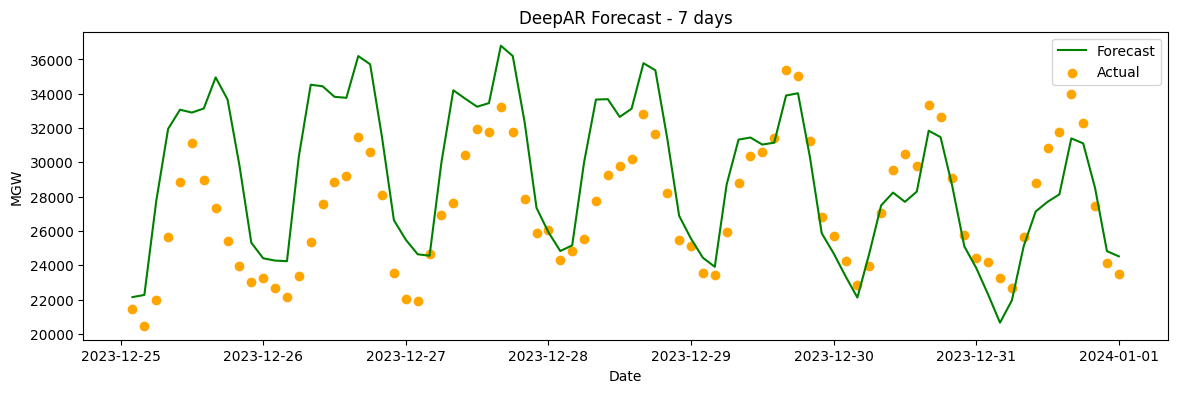

In [559]:
forecast_plot(forecast_df,test_days_2,days_to_predict)

In [560]:
mape_2 = mean_absolute_percentage_error(test_days_2["tsd"],forecast_df["median_prediction"])
rmse_2 = root_mean_squared_error(test_days_2["tsd"],forecast_df["median_prediction"])
rsqr_2 = r_squared(test_days_2["tsd"],forecast_df["median_prediction"])
print(f"MAPE with holiday: {round(mape_2,7)}")
print(f"RMSE with holiday: {round(rmse_2,7)}")
print(f"R-squared with holiday: {round(rsqr_2,7)}")

MAPE with holiday: 0.0961338
RMSE with holiday: 3339.8722313
R-squared with holiday: 0.1468602


model 3 training

In [525]:
df_model_3 = df_merged.set_index("settlement_date")

In [526]:
train_data_3 = df_model_3[:-split_from]
test_data_3 = df_model_3[-split_from:]
train_data_3, valid_data_3 = train_data_3[:val_split_index], train_data_3[val_split_index:]

In [527]:
estimator = DeepAREstimator(freq=freq,
                            context_length=context_length,
                            prediction_length=prediction_length,
                            use_feat_dynamic_real =True, # weather temp
                            num_layers=num_layers,
                            cardinality = [1,1],
                            batch_size=batch_size,
                            dropout_rate=dropout_rate,
                            num_cells=num_cells,
                            trainer= Trainer(epochs=15,
                                              num_batches_per_epoch=num_batches_per_epoch,
                                              callbacks=[scheduler]
                                             )
                                              )

In [528]:
train_ds_3 = ListDataset([{"start": train_data_3.index[0],
                              "target": train_data_3.tsd,
                              "feat_dynamic_real": [train_data_3.temp],
                              "feat_dynamic_cat": [train_data_3.is_holiday],
                              }],
                           freq = freq)

valid_ds_3 = ListDataset(
                        [{"start":valid_data_3.index[0],
                          "target":valid_data_3.tsd,
                          "feat_dynamic_real": [valid_data_3.temp],
                          "feat_dynamic_cat": [valid_data_3.is_holiday],}],
                        freq=freq)



In [529]:
#next(iter(train_ds_3))

In [530]:
m3 = estimator.train(training_data=train_ds_3, validation_data=valid_ds_3)

100%|██████████| 190/190 [01:49<00:00,  1.73it/s, epoch=1/15, avg_epoch_loss=9.12]
1it [00:00,  3.00it/s, epoch=1/15, validation_avg_epoch_loss=8.82]
100%|██████████| 190/190 [01:48<00:00,  1.75it/s, epoch=2/15, avg_epoch_loss=8.6]
1it [00:00,  2.96it/s, epoch=2/15, validation_avg_epoch_loss=8.67]
100%|██████████| 190/190 [01:49<00:00,  1.74it/s, epoch=3/15, avg_epoch_loss=8.58]
1it [00:00,  2.96it/s, epoch=3/15, validation_avg_epoch_loss=8.68]
100%|██████████| 190/190 [01:49<00:00,  1.74it/s, epoch=4/15, avg_epoch_loss=8.57]
1it [00:00,  2.89it/s, epoch=4/15, validation_avg_epoch_loss=8.68]
100%|██████████| 190/190 [01:49<00:00,  1.74it/s, epoch=5/15, avg_epoch_loss=8.57]
1it [00:00,  2.99it/s, epoch=5/15, validation_avg_epoch_loss=8.68]
100%|██████████| 190/190 [01:49<00:00,  1.74it/s, epoch=6/15, avg_epoch_loss=8.56]
1it [00:00,  2.72it/s, epoch=6/15, validation_avg_epoch_loss=8.68]
100%|██████████| 190/190 [01:48<00:00,  1.76it/s, epoch=7/15, avg_epoch_loss=8.56]
1it [00:00,  2.85i

In [543]:
test_ds_3 = ListDataset([{"start": test_data_3.index[0],
                              "target": test_data_3.tsd,
                              "feat_dynamic_real": [test_data_3.temp],
                              "feat_dynamic_cat": [test_data_3.is_holiday],
                              }],
                           freq = freq)

In [544]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds_3,
    predictor=m3,
    num_samples=100
)
forecasts = list(forecast_it)
tss = list(ts_it)

In [545]:
start_date = forecasts[0].start_date.start_time
samples = forecasts[0].quantile(0.5).T
index = pd.date_range(start=start_date, periods=len(samples), freq=freq)
forecast_df = pd.DataFrame(samples, index=index)
forecast_df.columns = ["median_prediction"]
forecast_df

,median_prediction
2023-12-25 02:00:00,22115.451172
2023-12-25 04:00:00,22704.566406
2023-12-25 06:00:00,27588.806641
2023-12-25 08:00:00,33535.671875
2023-12-25 10:00:00,35101.820312
...,...
2023-12-31 16:00:00,37039.730469
2023-12-31 18:00:00,35208.667969
2023-12-31 20:00:00,31306.498047
2023-12-31 22:00:00,26276.972656


In [546]:
test_days_3 = test_data_3[(test_data_3.index >= forecast_df.index[0])&(test_data_3.index <= forecast_df.index[-1])]
test_days_3

,tsd,is_holiday,temp
settlement_date,,,
2023-12-25 02:00:00,21430.75,1.0,13.15
2023-12-25 04:00:00,20477.50,1.0,13.30
2023-12-25 06:00:00,21974.75,1.0,12.80
2023-12-25 08:00:00,25665.00,1.0,12.05
2023-12-25 10:00:00,28835.50,1.0,12.30
...,...,...,...
2023-12-31 16:00:00,34006.00,0.0,7.60
2023-12-31 18:00:00,32273.00,0.0,8.20
2023-12-31 20:00:00,27456.50,0.0,8.45


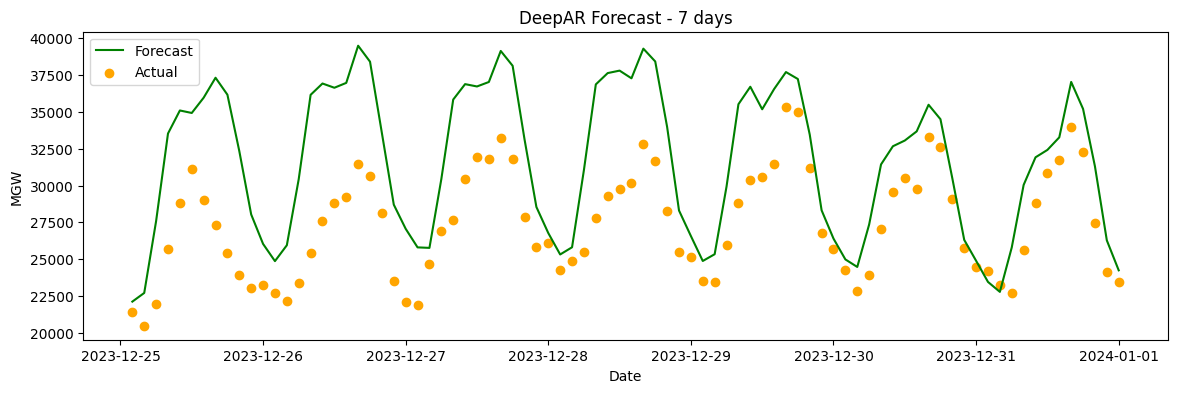

In [547]:
forecast_plot(forecast_df,test_days_3,days_to_predict)

In [548]:
mape_3 = mean_absolute_percentage_error(test_days_3["tsd"],forecast_df["median_prediction"])
rmse_3 = root_mean_squared_error(test_days_3["tsd"],forecast_df["median_prediction"])
rsqr_3 = r_squared(test_days_3["tsd"],forecast_df["median_prediction"])
print(f"MAPE with holiday: {round(mape_3,7)}")
print(f"RMSE with holiday: {round(rmse_3,7)}")
print(f"R-squared with holiday: {round(rsqr_3,7)}")

MAPE with holiday: 0.1562547
RMSE with holiday: 5094.5024732
R-squared with holiday: -0.9850161
